In [3]:
import os

import numpy as np
from typing import List, Tuple, Any, Dict

import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import json

import project_path

In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
DIR_ASSIGNMENTS = "../data/model_output/exp_v05"
DIR_ATTENTION_GROUND_TRUTH = "../data/ground_truth_attention/exp_v05"

# Read Data

## Ground Truth

In [5]:
def read_artificial_ground_truth(folder_ground_truth: str) -> Dict[str, Dict[str, Any]]:
    """Read ground-truth attention created when creating prompts.
    
    It returns a dictionary where the keys are the prompt file names (e.g.
    prompt_1.txt), so that from the model output we can derive the ground-truth
    attention.
    """
    ground_truth = {}
    for file in os.listdir(folder_ground_truth):
        if file.endswith(".json"):
            with open(os.path.join(folder_ground_truth, file), "r") as f:
                ground_truth[file.replace(".json", "")] = json.load(f)
    return ground_truth

ground_truth = read_artificial_ground_truth(DIR_ATTENTION_GROUND_TRUTH)
ground_truth["prompt_0_assignment_chain"]["attention_weights"]

[0,
 0,
 0.2222222222222222,
 0,
 0.2222222222222222,
 0.5555555555555556,
 0.5555555555555556,
 0.8888888888888888,
 0,
 0,
 1.0]

## Model Output

In [6]:
from attwizard.script.utils_model import read_model_output

data = read_model_output(DIR_ASSIGNMENTS)

In [7]:
data[0].keys()

dict_keys(['name', 'metadata', 'matrix'])

In [8]:
data[0]["metadata"].keys()

dict_keys(['tokens_all', 'tokens_prompt', 'tokens_generated', 'text_generated', 'text_prompt', 'config_options', 'generation_time_seconds'])

In [9]:
print(data[0]["metadata"]["text_generated"])

var_0 = 76
var_1 = 85
var_2 = 85
var_3 = 1
var_4 = 33
var_5 = 83
derived_0 = var_2 + var_0
derived_1 = var_5 / var_2
derived_2 = var_0 * derived_1
derived_3 = var_5 + var_2
print(derived_2) # prints the value "715"<|endoftext|>


prompt_3_assignment_chain.txt_Salesforce_codegen-16B-mono


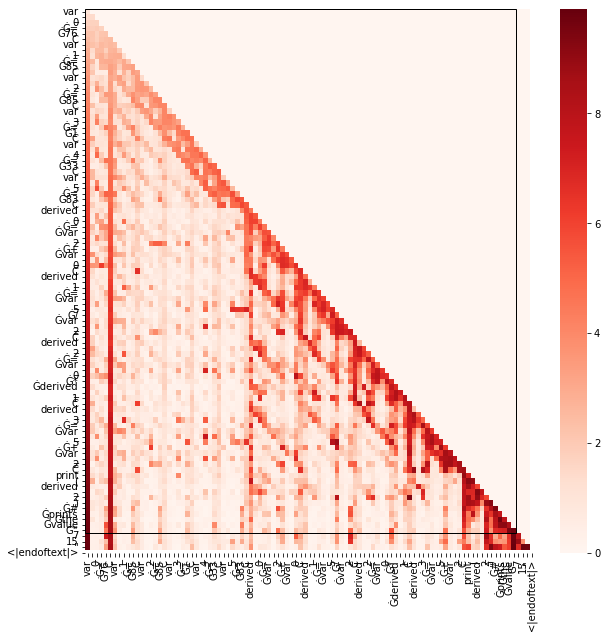

prompt_9_assignment_chain.txt_Salesforce_codegen-16B-mono


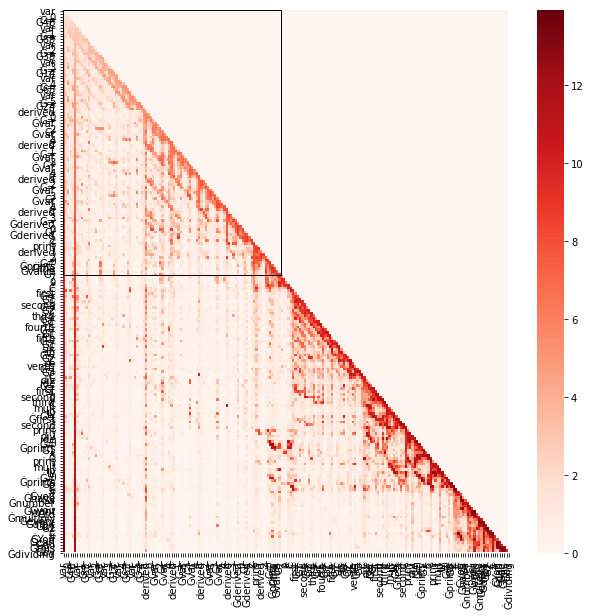

prompt_1_assignment_chain.txt_Salesforce_codegen-16B-mono


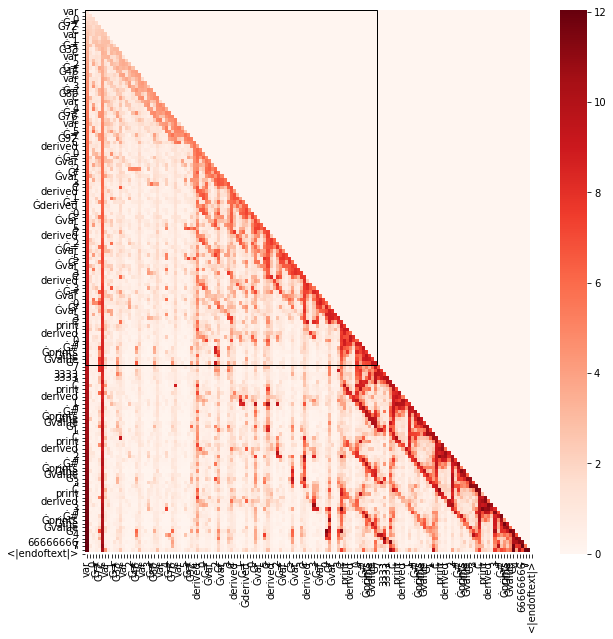

prompt_5_assignment_chain.txt_Salesforce_codegen-16B-mono


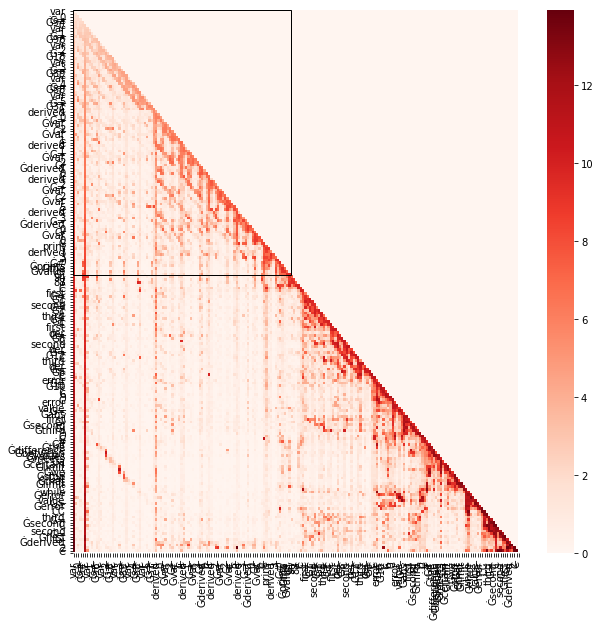

prompt_4_assignment_chain.txt_Salesforce_codegen-16B-mono


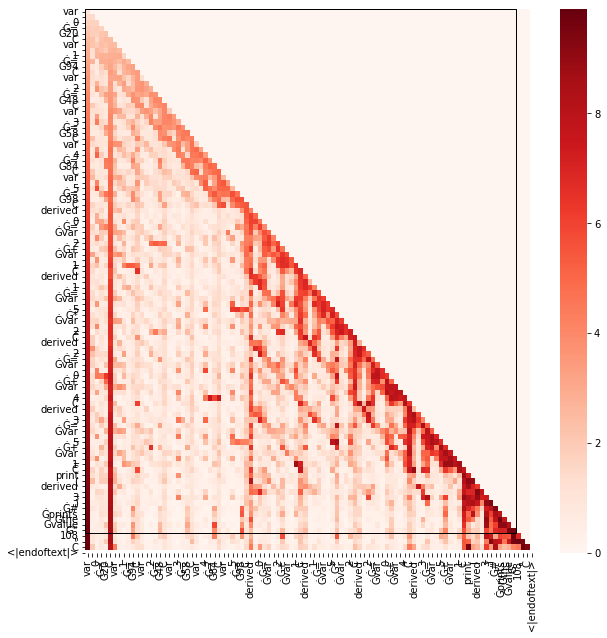

In [10]:
from attwizard.decoder import heatmap_visualize

for record in data[:5]:
    print("=" * 80)
    print(record["name"])
    heatmap_visualize(
        attention_matrix=record["matrix"],
        token_names=record["metadata"]["tokens_all"],
        n_input_tokens=len(record["metadata"]["tokens_prompt"])
    )
    plt.show()

## Visualize Heatmaps for first prediction

In [27]:
from ipywidgets import interact, fixed
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode


def show_attention_on_code(
        attention_matrix: np.ndarray,
        tokens: List[str],
        text_generated: str,
        token_pos: int,
        include_predecessors: bool = False):
    """Show the attention map of a specific token position."""
    print(f"You see the weights of attention to represent the token: {tokens[token_pos]}")
    print("And all the PREDECESSORS TOKENS as WELL (summed attention)")
    print(f"This token representation is used to predict all the tokens after this.")
    # extract the weights for that token representation
    if include_predecessors:
        att_matrix_c_token = attention_matrix[:token_pos, :]
        att_weights = att_matrix_c_token.sum(axis=0)  # <----- focus here
    else:
        att_weights = attention_matrix[token_pos, :]
    att_weights = list(att_weights.numpy()) \
        if isinstance(att_weights, torch.Tensor) else list(att_weights)
    # append 1 because the last token is unattended, it is simply generated 
    # attending the previous ones.
    att_weights.append(0)
    print(len(att_weights))
    # convert the attntion to char level (easier to compare and display)
    att_weights_char_level = map_to_char_level(
        tokens=tokens,
        att_weights=att_weights,
        raw_text=text_generated,
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(text_generated)
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_char_level,
        show_line_numbers=True
    )
    return fig, ax
    
POSITION = 0    
chosen_record = data[POSITION]

gpt_tokens_labels = [
    (t[1], t[0]) for t in list(enumerate(chosen_record["metadata"]["tokens_all"]))
]    

interact(
    show_attention_on_code, 
    token_pos=gpt_tokens_labels,
    attention_matrix=fixed(chosen_record["matrix"]),
    tokens=fixed(chosen_record["metadata"]["tokens_all"]),
    text_generated=fixed(chosen_record["metadata"]["text_generated"]),
    include_predecessors=fixed(False)
    )

interactive(children=(Dropdown(description='token_pos', options=(('var', 0), ('_', 1), ('0', 2), ('Ġ=', 3), ('…

<function __main__.show_attention_on_code(attention_matrix: numpy.ndarray, tokens: List[str], text_generated: str, token_pos: int, include_predecessors: bool = False)>

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
99


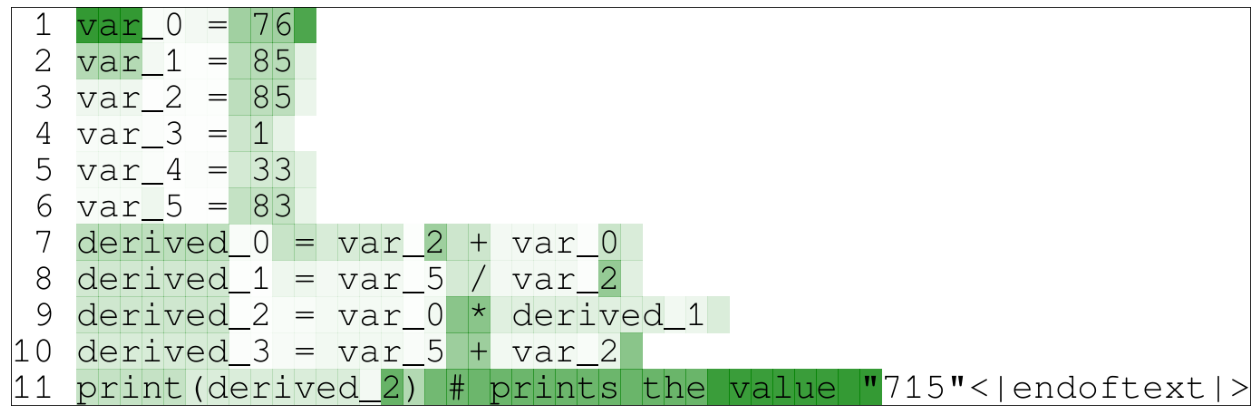

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
195


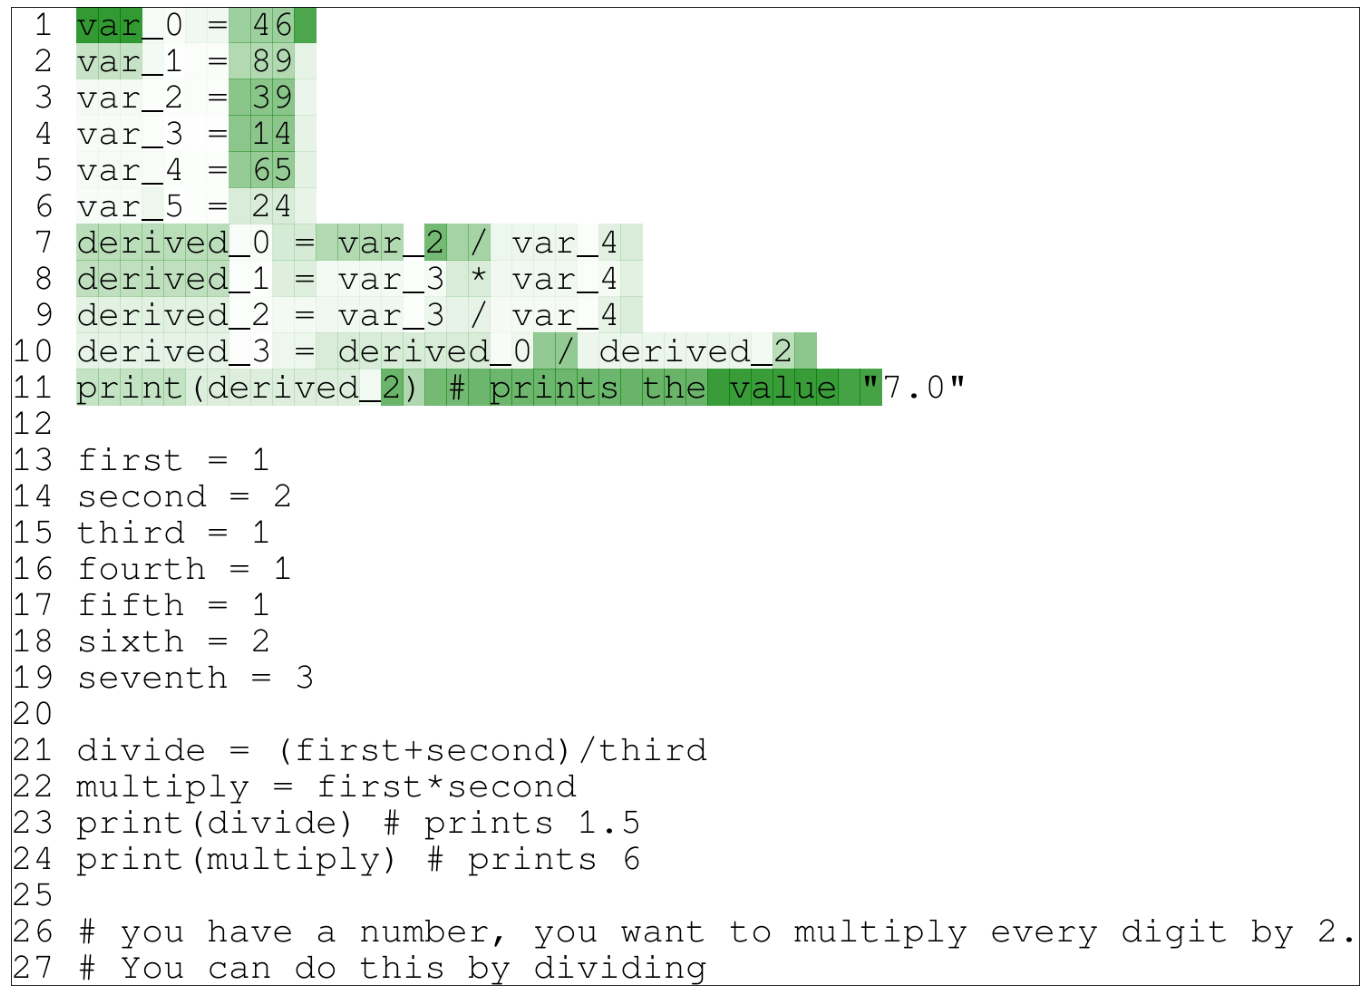

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
146


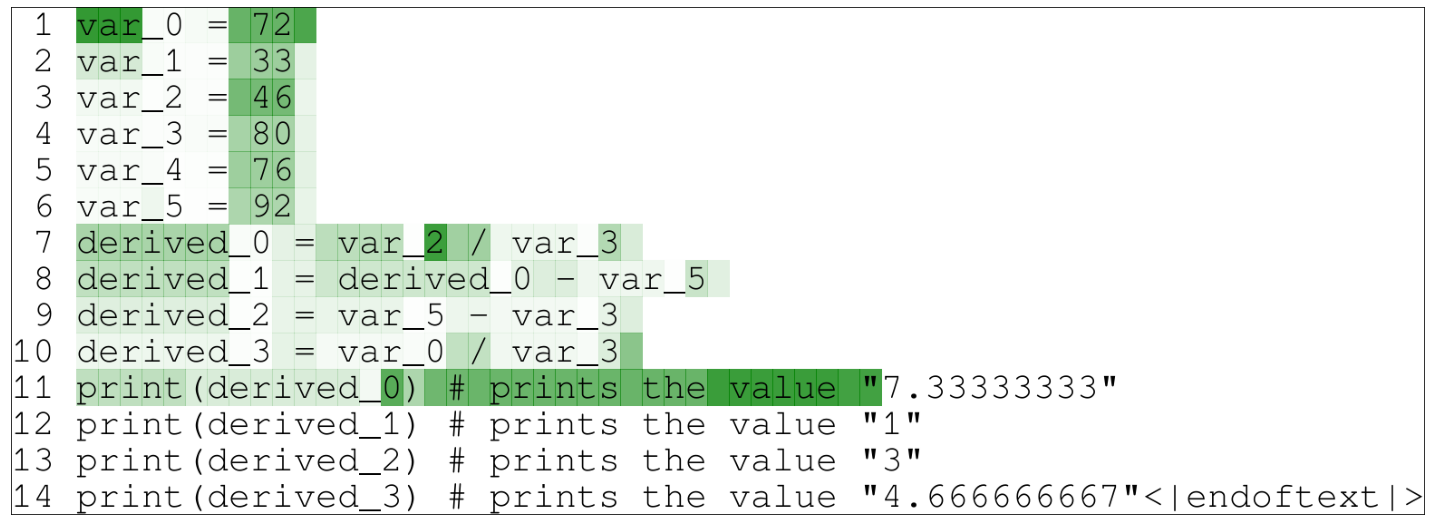

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
195


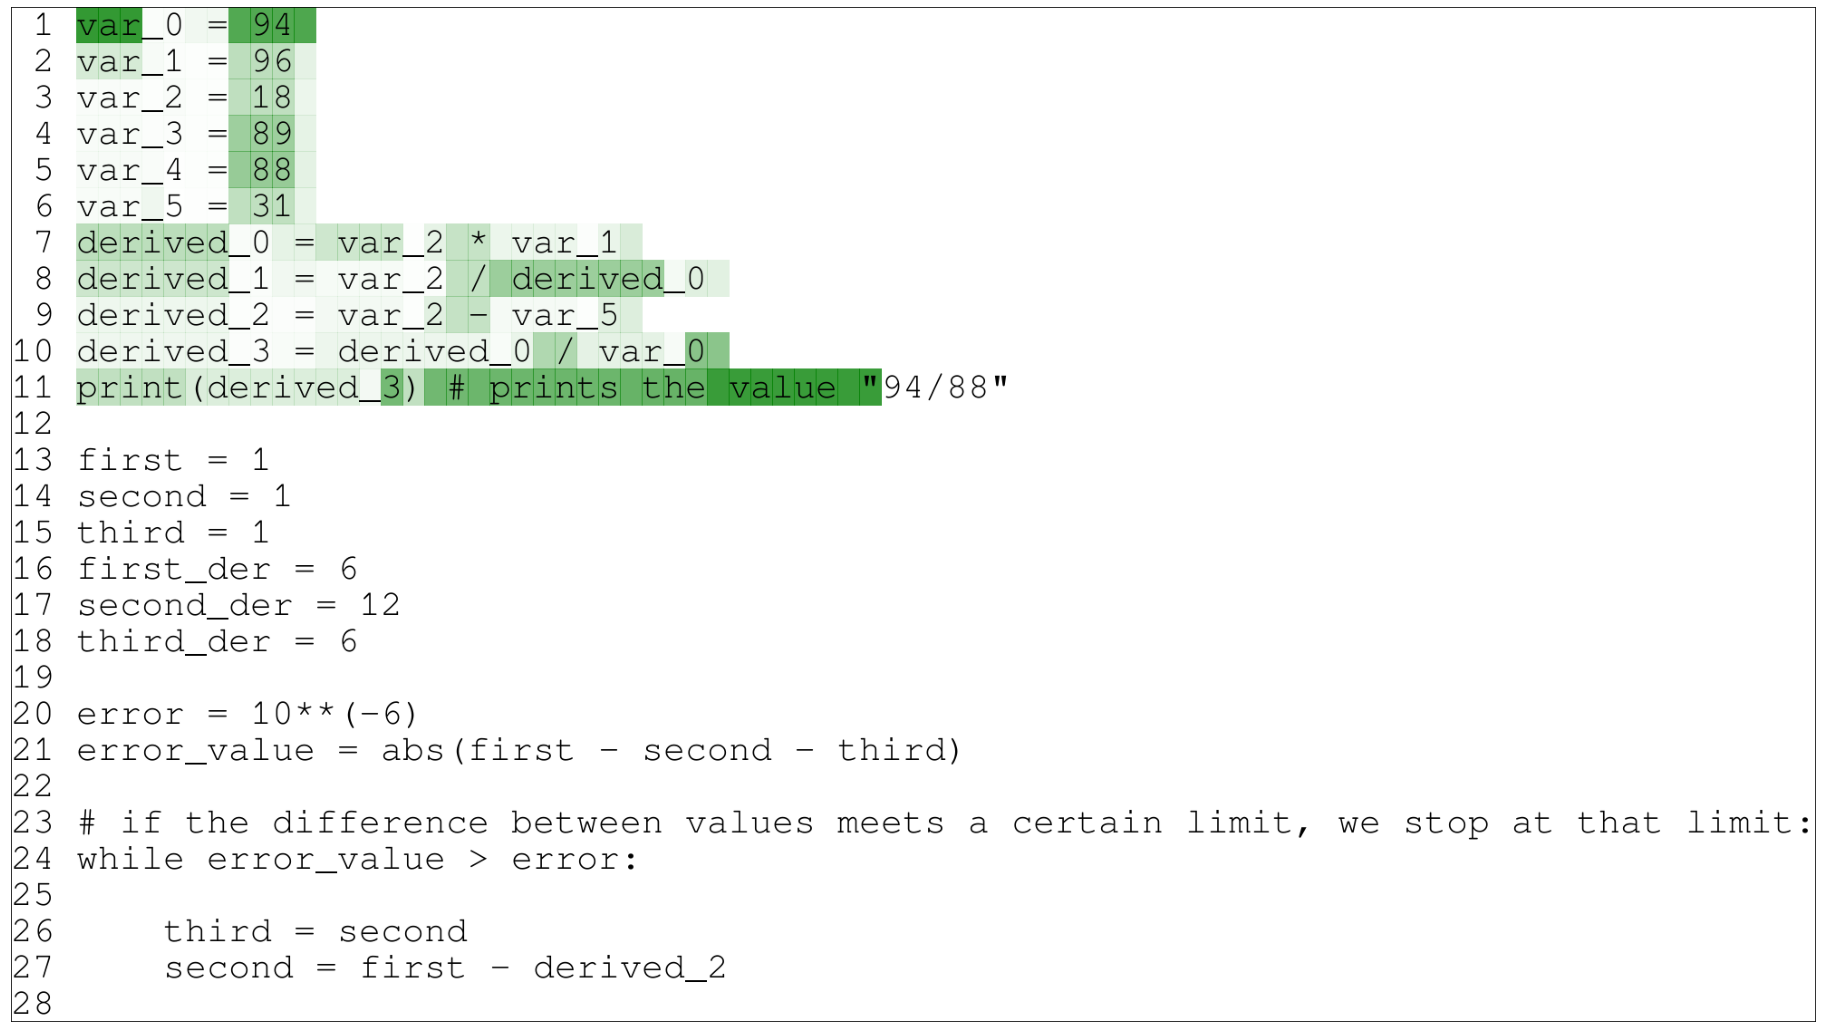

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
99


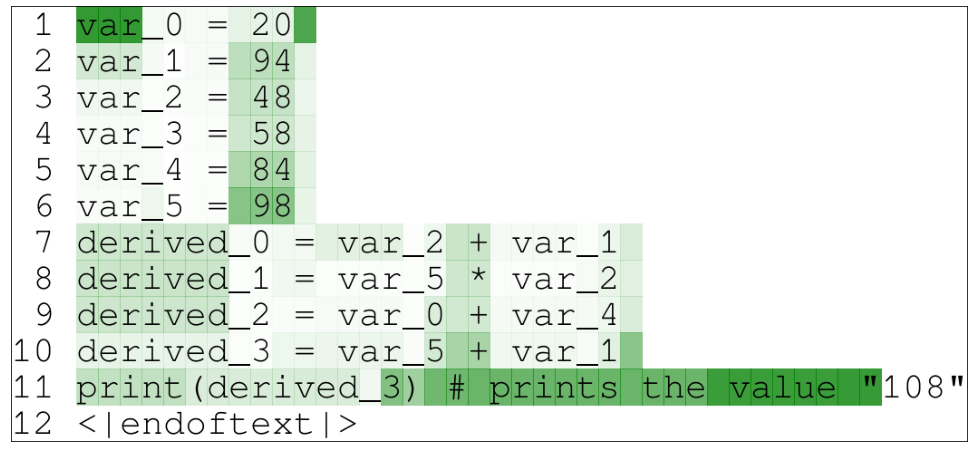

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
182


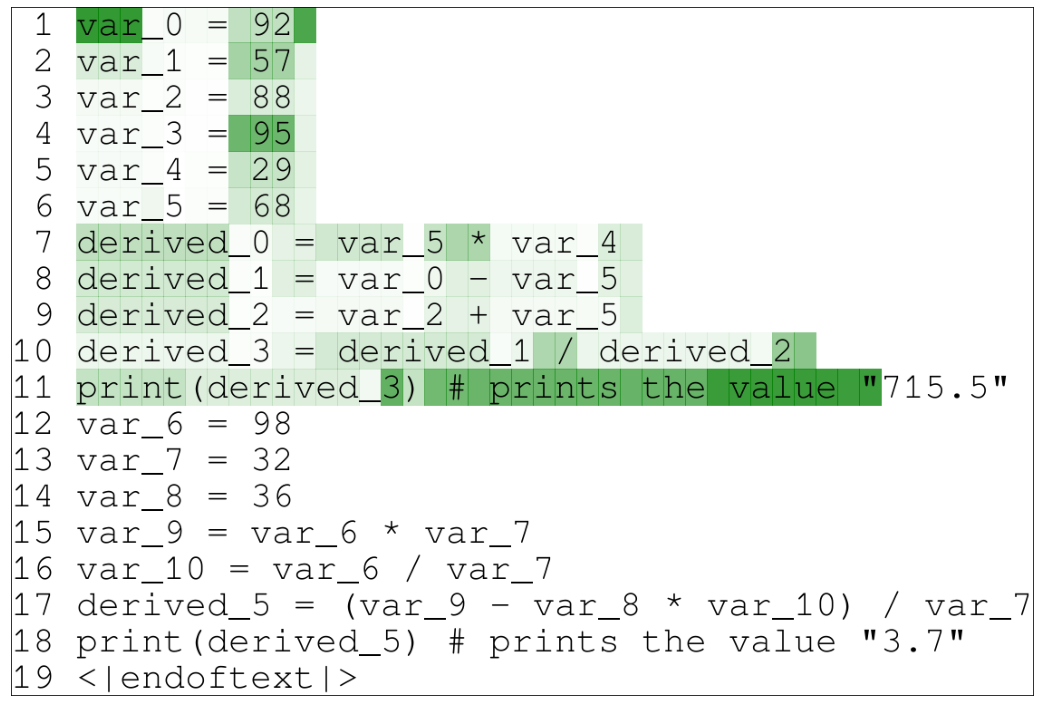

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
143


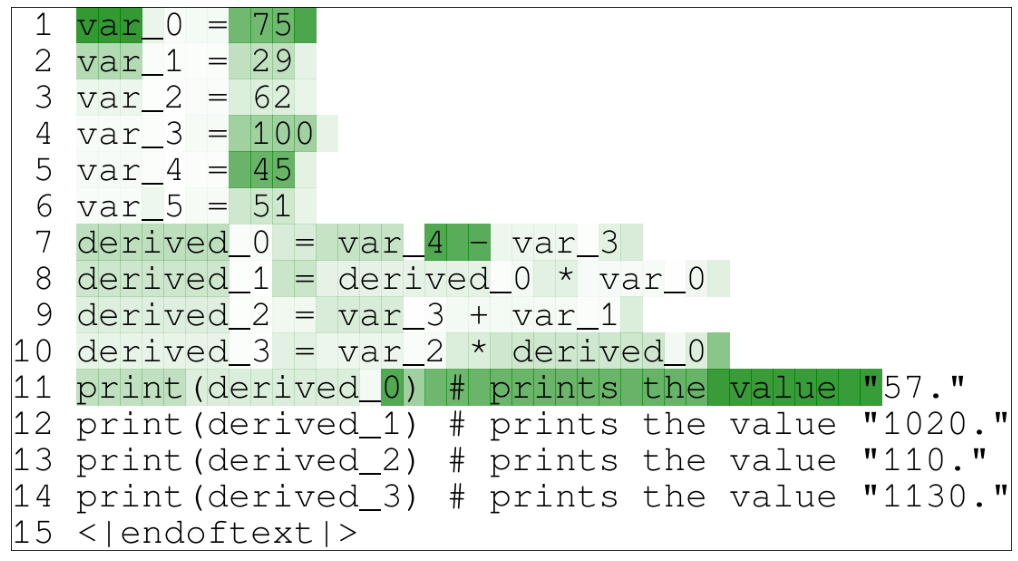

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
99


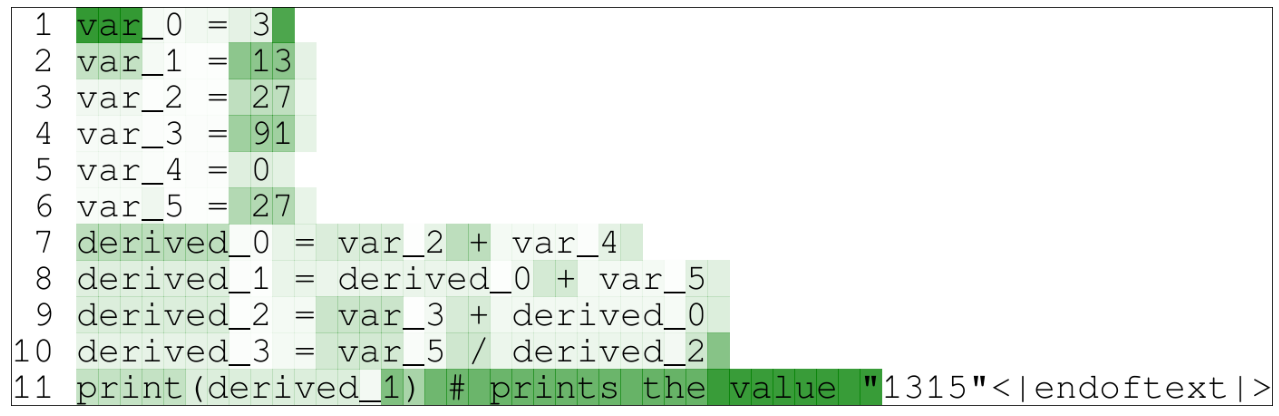

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
195


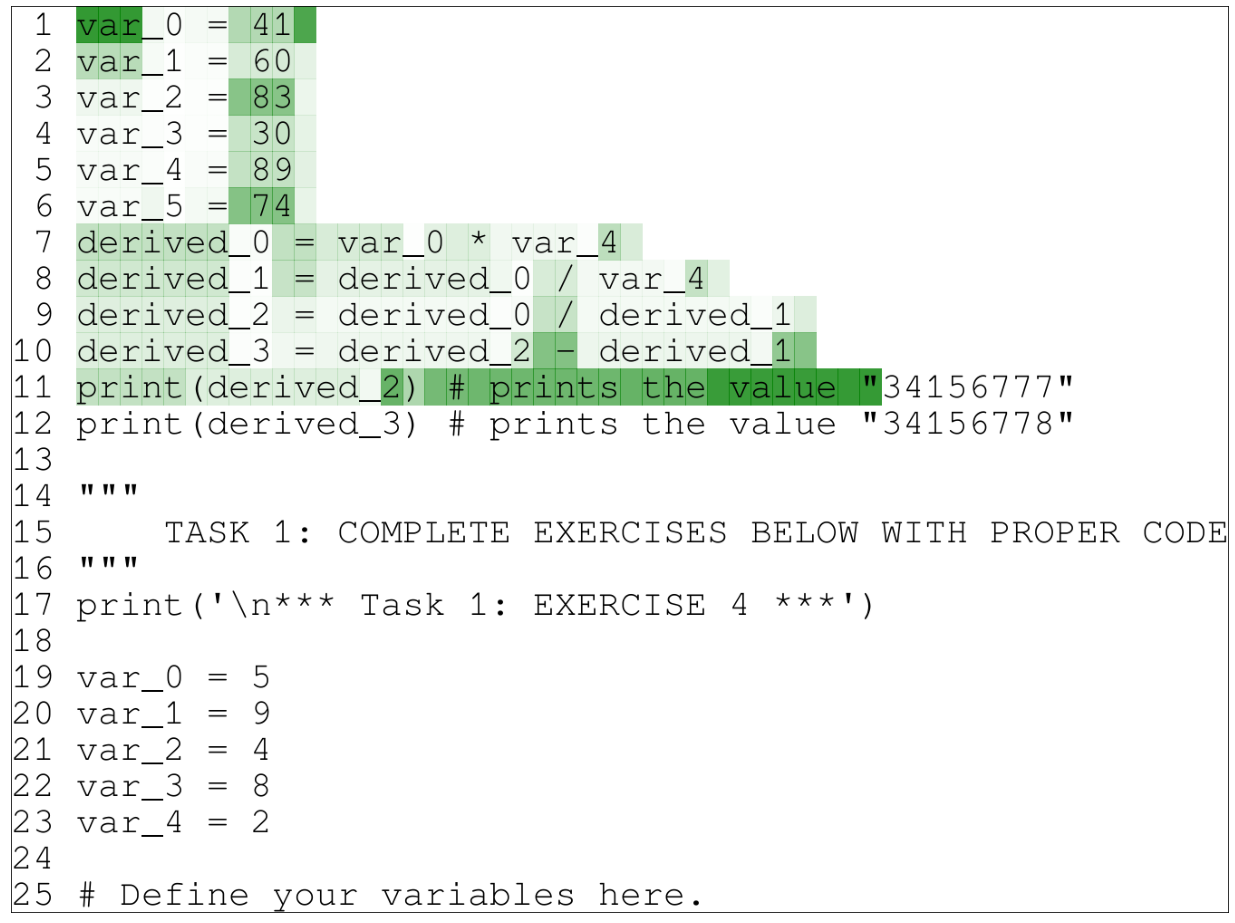

You see the weights of attention to represent the token: Ġ"
And all the PREDECESSORS TOKENS as WELL (summed attention)
This token representation is used to predict all the tokens after this.
147


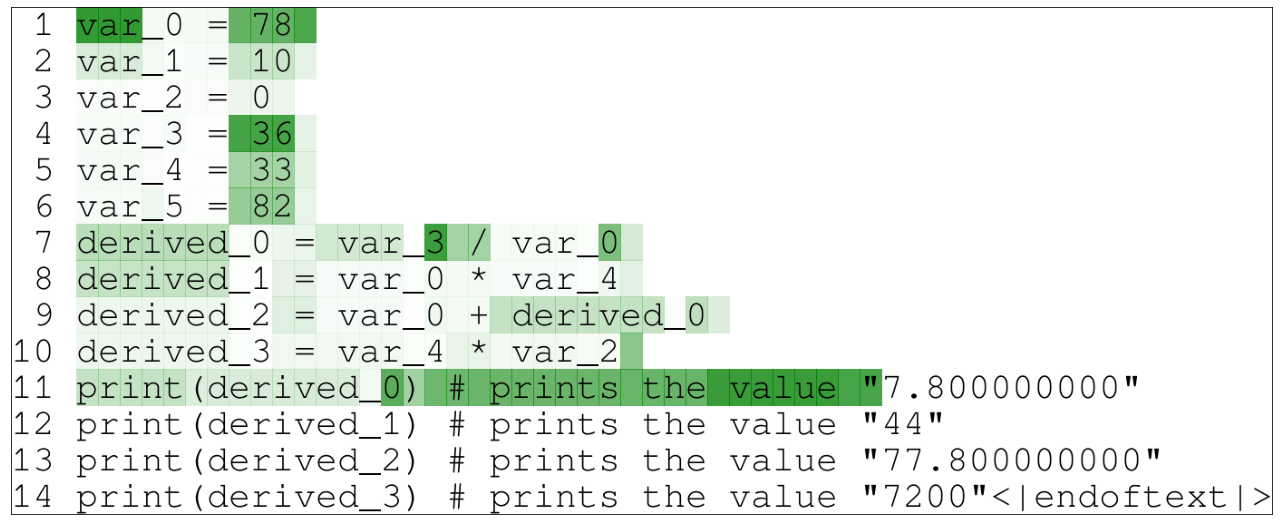

In [29]:
for chosen_record in data:
    show_attention_on_code(
        attention_matrix=chosen_record["matrix"],
        token_pos=len(chosen_record["metadata"]["tokens_prompt"]) - 1,
        tokens=chosen_record["metadata"]["tokens_all"],
        text_generated=chosen_record["metadata"]["text_generated"],
        include_predecessors=False)
    plt.show()

## Compare with Statement-Level Ground Truth

We consider the variable in the last statement the target variable, since we are trying to find something to relate to it with the `==` operator.
Thus, we hypotesize that all statement with that variable are somehow relevant for the prediction.

We then chceck how much the total attention given by the last statement to the other statements is alined with this logic: aka more attention to statement with the target variable.

We use the ROC curve to visualize the performance of binary classifier based on the attention score, since the attention scores are continuous whereas the relevance of the ground truth is either 0 for irrelevant or 1 for relevant.

In [11]:

from sklearn.metrics import roc_curve, auc, roc_auc_score
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level
from codeattention.source_code import SourceCode


def show_roc_curve(ground_truth_attention, att_all_statements):
    fpr, tpr, _ = roc_curve(ground_truth_attention, att_all_statements)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

In [17]:
a = np.array([1, 2, 3, 4])
np.where(a > 0.5, True, False)

array([ True,  True,  True,  True])

prompt_3_assignment_chain.txt_Salesforce_codegen-16B-mono
[True, False, True, False, False, True, False, True, True, False, True]
[247.12653, 80.48544, 47.96359, 45.48845, 43.39463, 49.037365, 215.94354, 146.74557, 180.00926, 231.10046, 413.89453]
prompt_3_assignment_chain - AUC: 0.6666666666666666


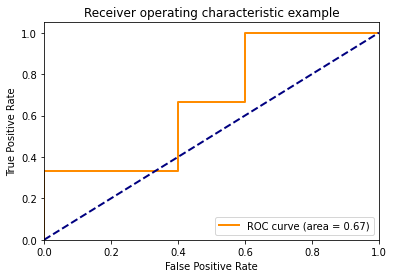

98 98


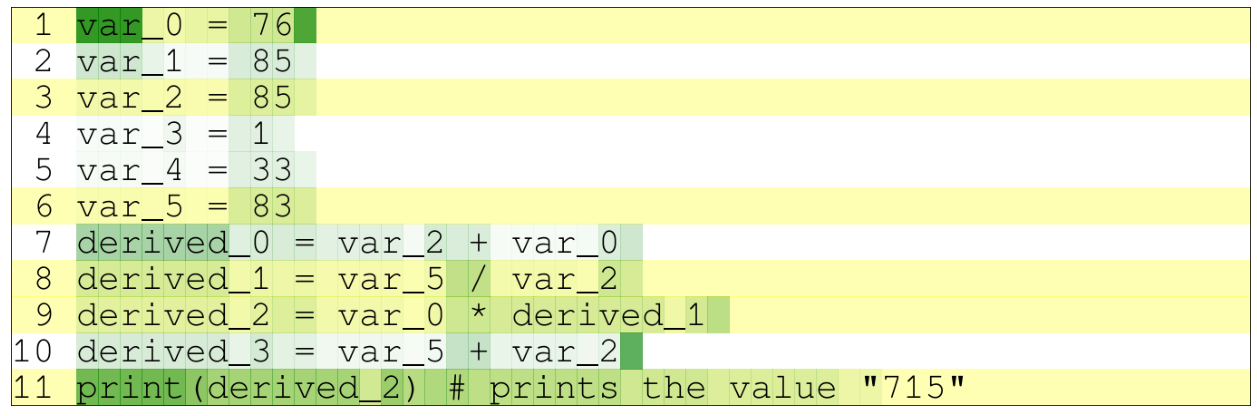

prompt_9_assignment_chain.txt_Salesforce_codegen-16B-mono
[False, False, False, True, True, False, False, False, True, False, True]
[245.5791, 79.02194, 66.27954, 53.02547, 48.90399, 42.30709, 228.88745, 114.98043, 128.32803, 304.17035, 409.2153]
prompt_9_assignment_chain - AUC: 0.4642857142857143


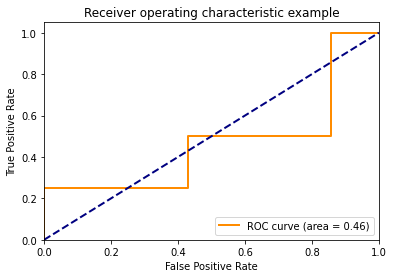

194 194


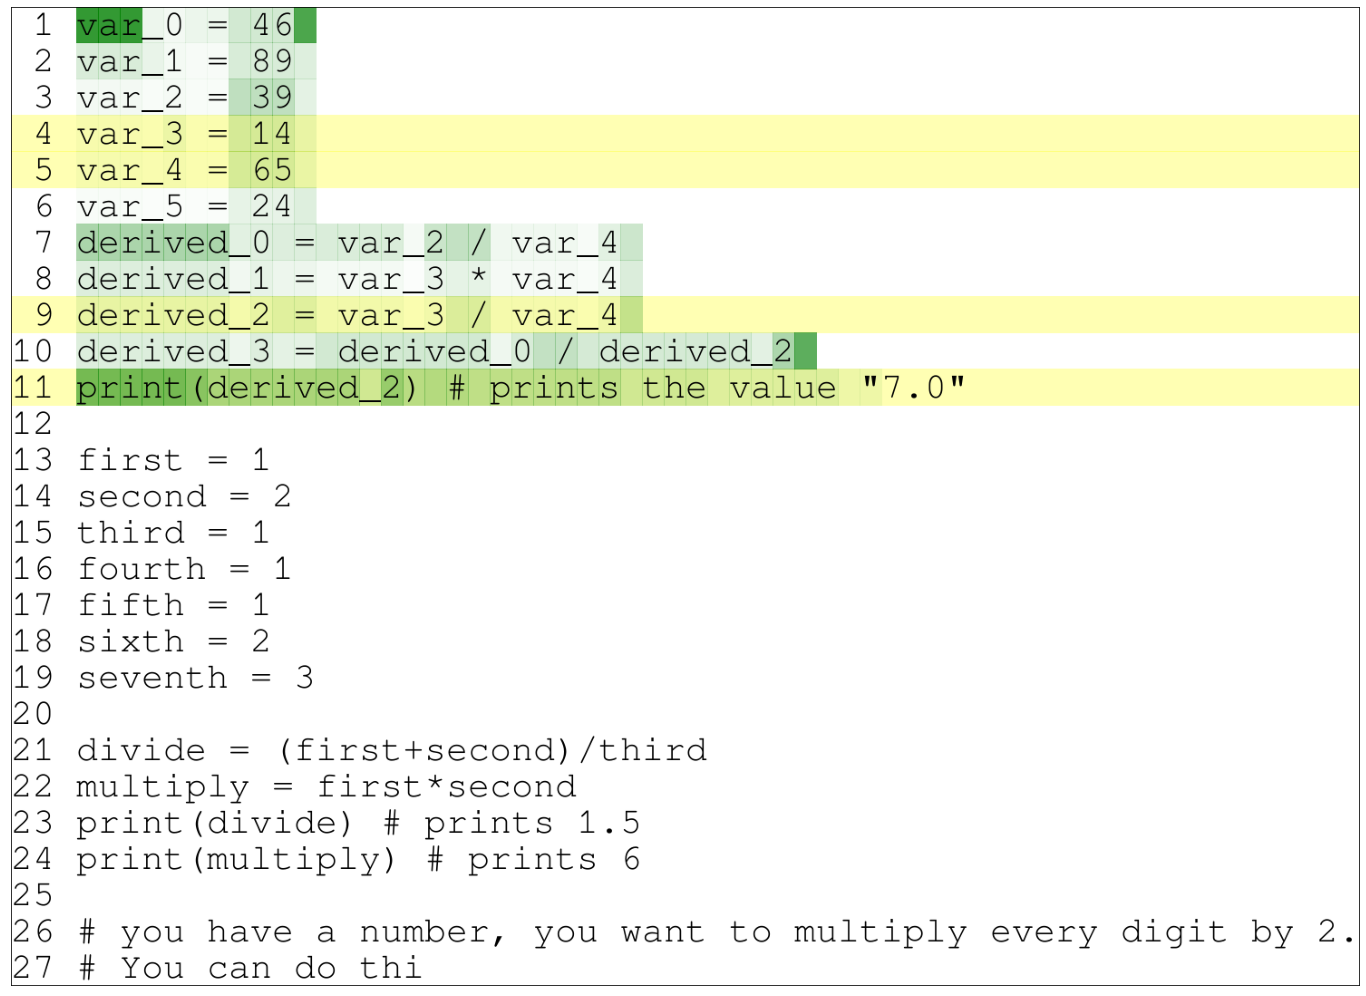

prompt_1_assignment_chain.txt_Salesforce_codegen-16B-mono
[False, False, True, True, False, False, True, False, False, False, True]
[259.80432, 78.01136, 51.075943, 47.238804, 42.518723, 44.614536, 264.956, 180.50032, 109.96178, 232.55484, 418.65637]
prompt_1_assignment_chain - AUC: 0.6428571428571428


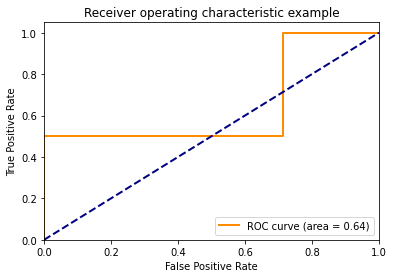

145 145


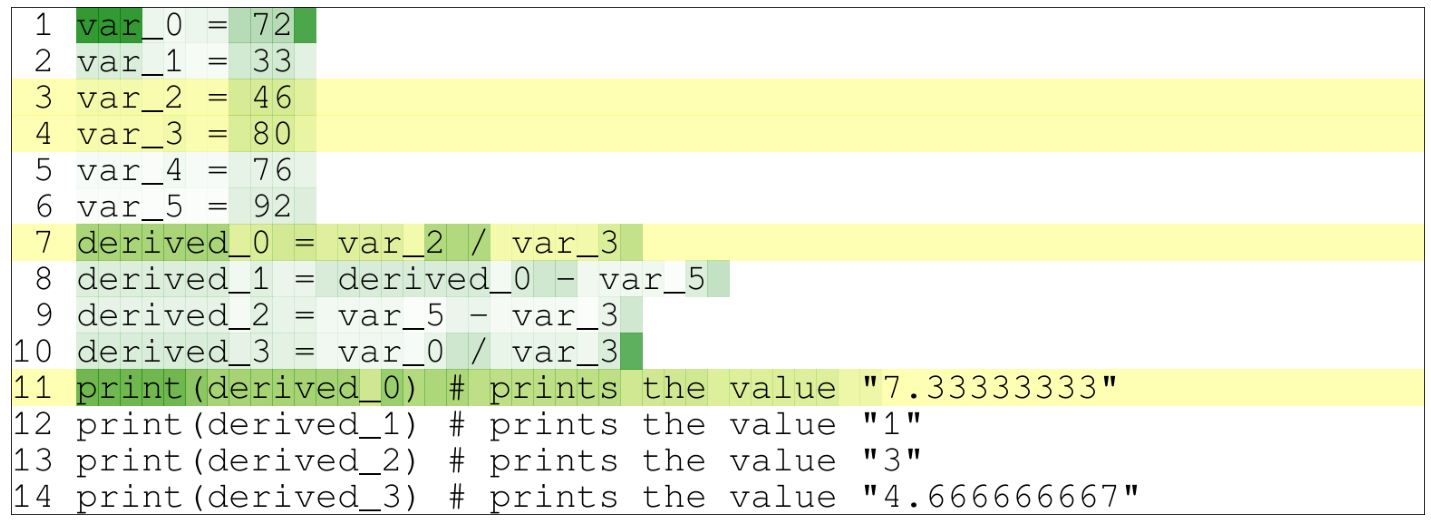

prompt_5_assignment_chain.txt_Salesforce_codegen-16B-mono
[True, True, True, False, False, False, True, False, False, True, True]
[258.81146, 75.261696, 46.808952, 61.52149, 50.44053, 50.421852, 188.78189, 162.41403, 129.93277, 308.50623, 406.67053]
prompt_5_assignment_chain - AUC: 0.7666666666666666


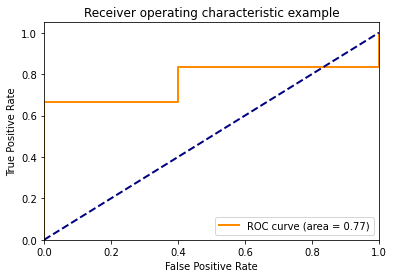

194 194


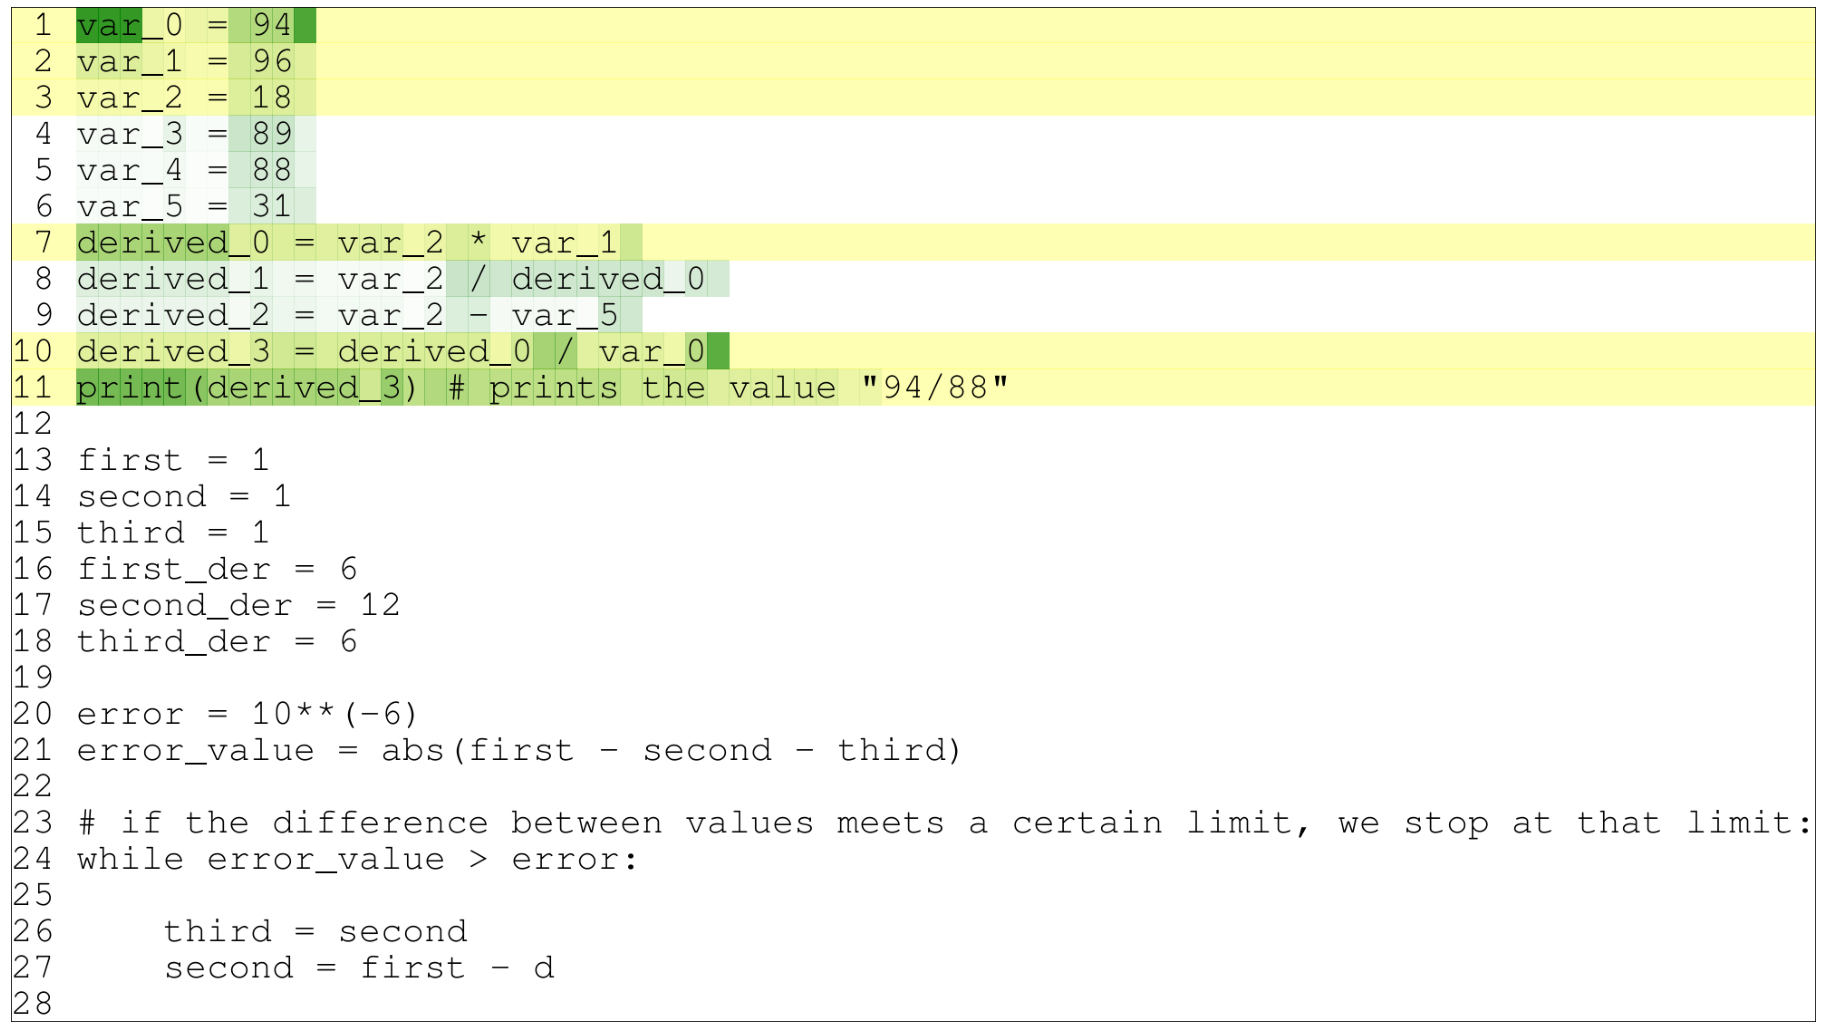

prompt_4_assignment_chain.txt_Salesforce_codegen-16B-mono
[False, True, False, False, False, True, False, False, False, True, True]
[235.50699, 73.98947, 46.171333, 49.426537, 49.944466, 57.43331, 200.34883, 125.29904, 133.25485, 262.26245, 417.28036]
prompt_4_assignment_chain - AUC: 0.7142857142857143


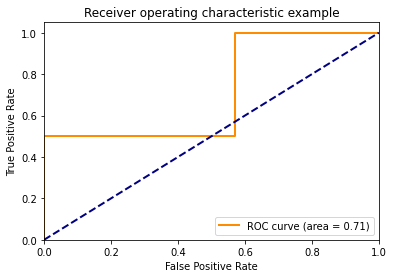

98 98


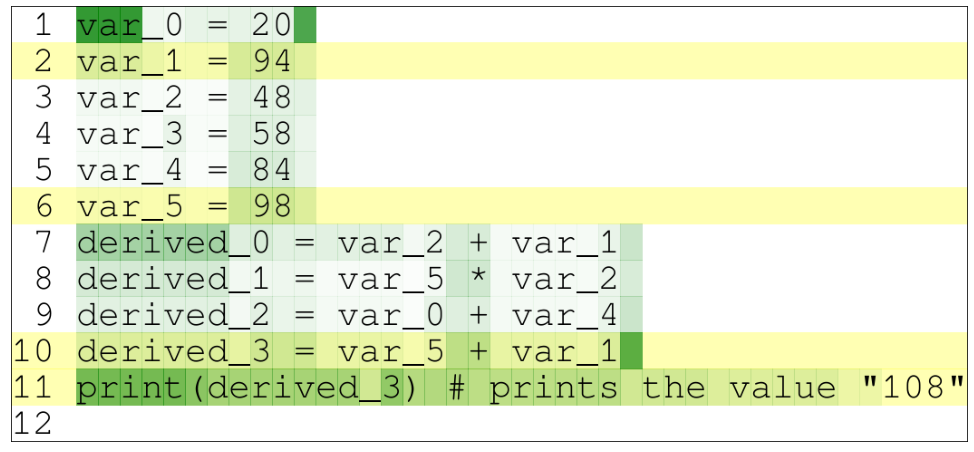

prompt_7_assignment_chain.txt_Salesforce_codegen-16B-mono
[True, False, True, False, False, True, False, True, True, True, True]
[241.86963, 82.87613, 42.532227, 73.227005, 42.12695, 41.4944, 203.04832, 107.32593, 101.74657, 350.16235, 399.6919]
prompt_7_assignment_chain - AUC: 0.6785714285714285


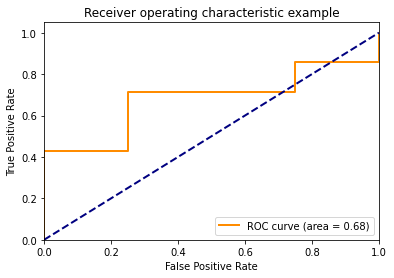

181 181


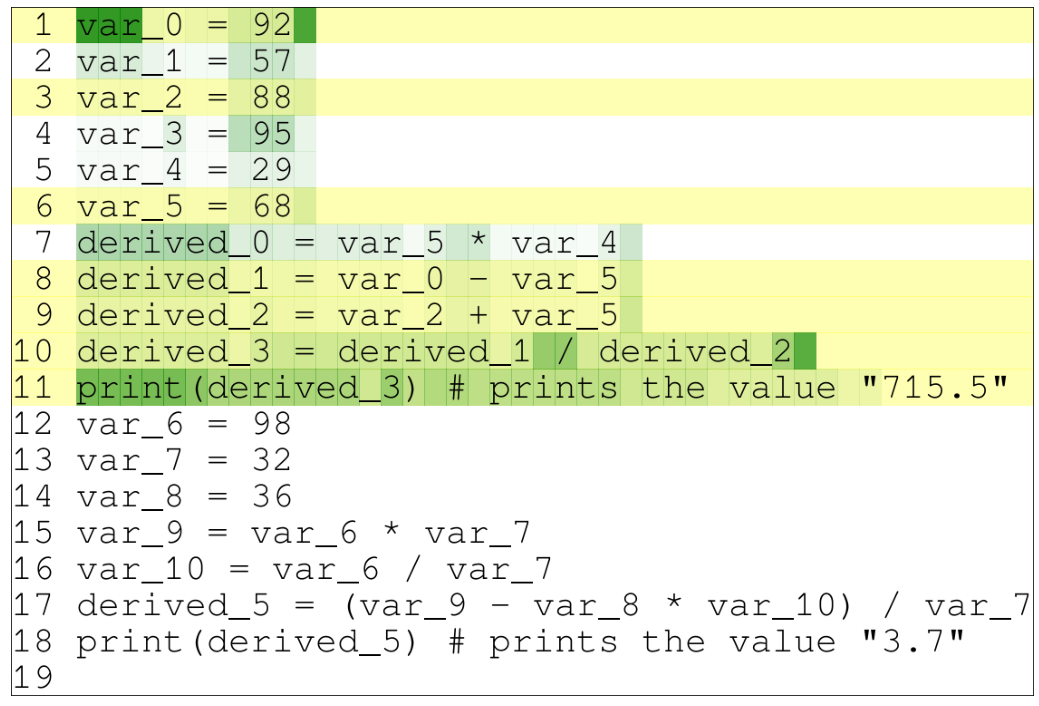

prompt_2_assignment_chain.txt_Salesforce_codegen-16B-mono
[False, False, False, True, True, False, True, False, False, False, True]
[261.45697, 77.11065, 42.326336, 52.437927, 56.32138, 41.74253, 254.66846, 157.72481, 106.965576, 246.60138, 423.33282]
prompt_2_assignment_chain - AUC: 0.6071428571428571


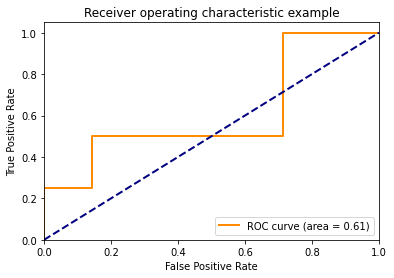

142 142


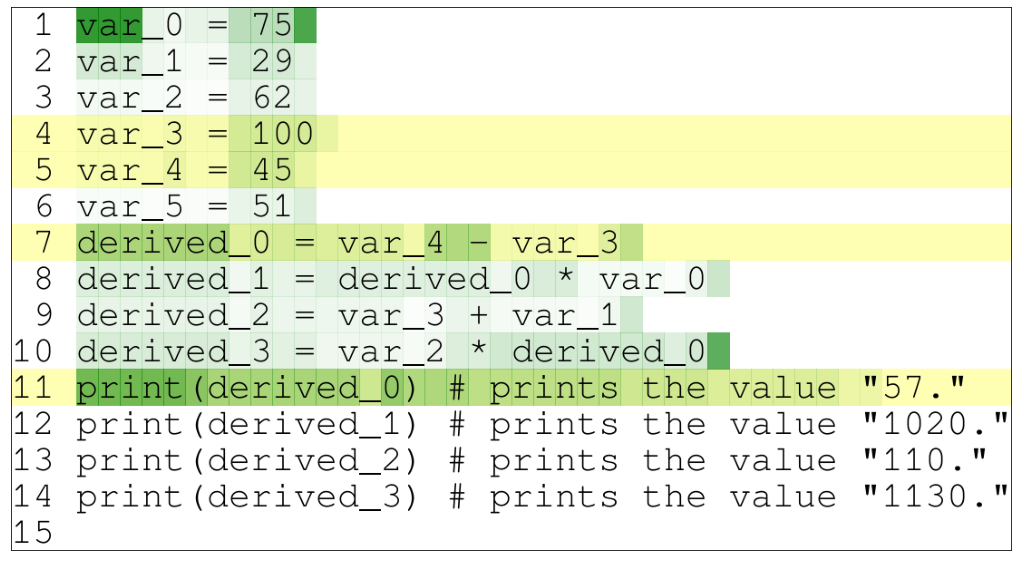

prompt_0_assignment_chain.txt_Salesforce_codegen-16B-mono
[False, False, True, False, True, True, True, True, False, False, True]
[236.38266, 84.47018, 46.519455, 54.219925, 40.46259, 48.88121, 190.54387, 166.22377, 143.18709, 281.025, 413.48663]
prompt_0_assignment_chain - AUC: 0.36666666666666664


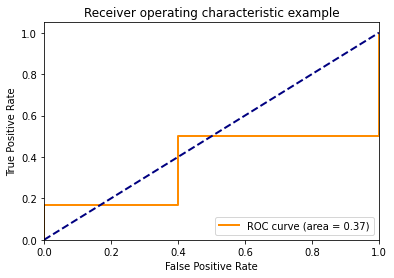

98 98


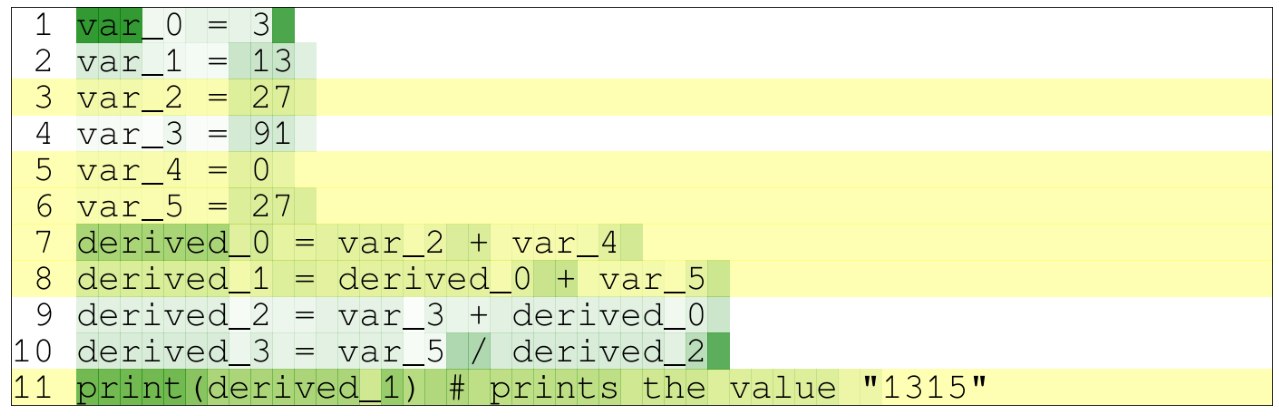

prompt_6_assignment_chain.txt_Salesforce_codegen-16B-mono
[True, False, False, False, True, False, True, True, True, False, True]
[242.98431, 73.644, 68.41936, 51.827366, 45.657475, 55.312523, 188.59877, 160.21204, 150.08936, 298.09778, 416.85004]
prompt_6_assignment_chain - AUC: 0.7000000000000001


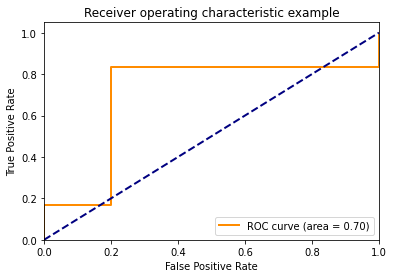

194 194


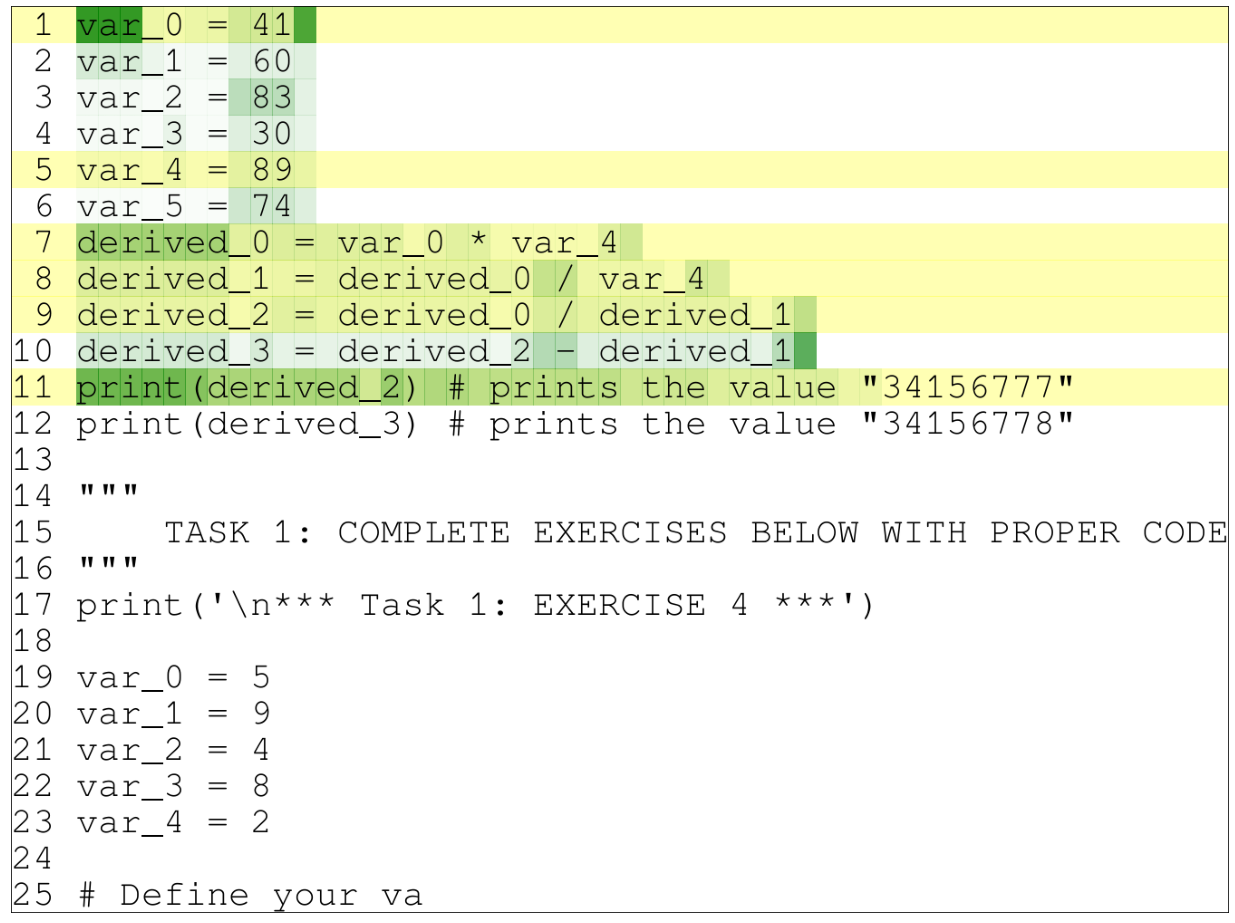

prompt_8_assignment_chain.txt_Salesforce_codegen-16B-mono
[True, False, False, True, False, False, True, False, False, False, True]
[257.76428, 72.02408, 35.777225, 70.31217, 47.223732, 48.637978, 302.21558, 112.26202, 151.58505, 211.02484, 413.67758]
prompt_8_assignment_chain - AUC: 0.8571428571428572


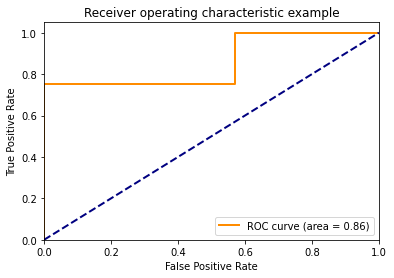

146 146


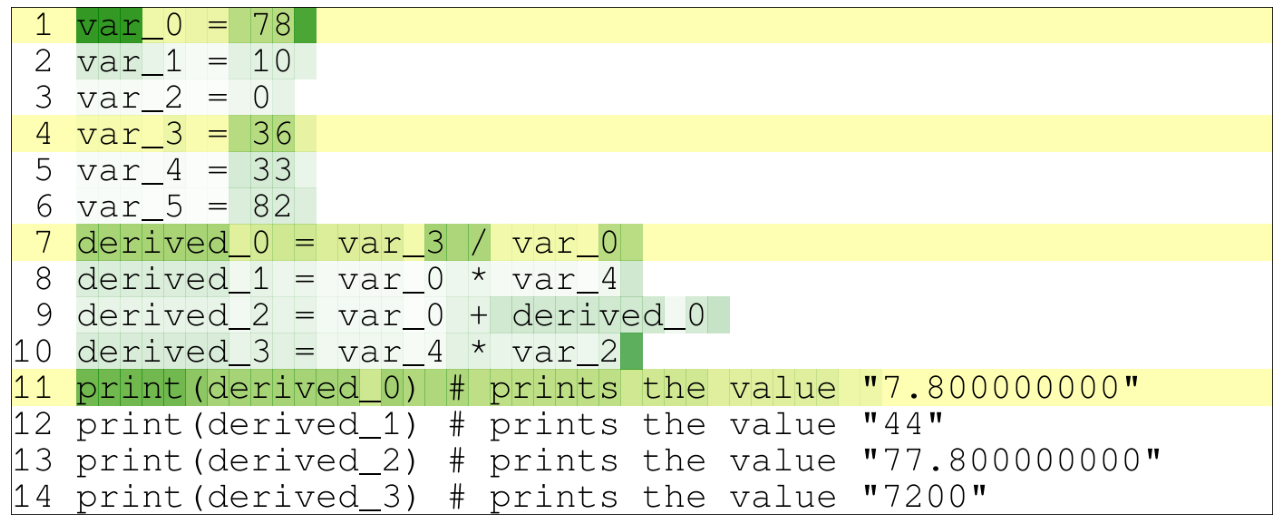

Mean AUC:  0.6464285714285714


In [31]:
# GET STATEMENT-LEVEL ATTENTION FROM LAST STATMENT WEIGHTS
# we focus on the attention paid by the last statement
# we want to see how much those toknes are paying ot each of the previous 
# statements
all_roc_scores = []

for chosen_record in data[:]:
    # get its ground-truth
    basename = chosen_record["name"][:chosen_record["name"].find(".")]
    ground_truth_attention = ground_truth[basename]["attention_weights"]
    # binarize
    ground_truth_attention = list(
        np.where(np.array(ground_truth_attention) > 0, True, False))
    print("=" * 80)
    print(chosen_record["name"])

    # get the attention weights for the last statment of the prompt
    att_matrix = chosen_record["matrix"]

    tokens_prompt = chosen_record["metadata"]["tokens_prompt"]
    idx_last_token_prompt = len(tokens_prompt) - 1
    idx_last_new_line_char = len(tokens_prompt) - tokens_prompt[::-1].index("Ċ") - 1
    idx_first_char_last_statement = idx_last_new_line_char + 1

    # attention weigths of last statement
    att_weights_on_prompt_from_last_statement = \
        att_matrix[
            idx_first_char_last_statement:idx_last_token_prompt + 1, :].sum(axis=0)

    # get attention on the preceeding statement
    att_all_statements = []
    remaining_tokens = tokens_prompt[:idx_first_char_last_statement]
    remaining_att_weights = att_weights_on_prompt_from_last_statement
    #print(remaining_att_weights)

    while True:
        try:
            idx_next_first_line = remaining_tokens.index("Ċ")
        except ValueError:
            # sum remaining tokens
            # print("last statement hit.")
            # attention that the tokens of the last staement put on themselves
            statement_att = remaining_att_weights.sum()
            att_all_statements.append(statement_att)
            break 
        # sum attention matrix until the next line break
        # print("sum attention of tokens:")
        # print(remaining_tokens[:idx_next_first_line + 1])
        statement_att = remaining_att_weights[: idx_next_first_line + 1].sum()
        att_all_statements.append(statement_att)
        # update remaining tokens and attention matrix
        remaining_tokens = remaining_tokens[idx_next_first_line + 1:]
        remaining_att_weights = remaining_att_weights[idx_next_first_line + 1:]

    assert len(att_all_statements) == len(ground_truth_attention)
    print(ground_truth_attention)
    print(att_all_statements)
    auc_score = roc_auc_score(ground_truth_attention, att_all_statements)
    all_roc_scores.append(auc_score)
    print(f"{basename} - AUC: {auc_score}")
    show_roc_curve(ground_truth_attention, att_all_statements)

    print(len(chosen_record["metadata"]["tokens_all"][:-1]), len(att_weights_on_prompt_from_last_statement))
    # Plot the attention
    att_weights_char_level = map_to_char_level(
        tokens=chosen_record["metadata"]["tokens_all"][:-1],
        att_weights=att_weights_on_prompt_from_last_statement,
        raw_text=chosen_record["metadata"]["text_generated"][:-len('<|endoftext|>')],  # <--- random fix 
        #distribution_fn="equal_share",
        distribution_fn="replication",
        special_char_mapping={
            "Ġ": ' ',
            "Ċ": '\n',
        }
    )
    char_tokens = tokenize_char_level(
        chosen_record["metadata"]["text_generated"])
    # display
    python_sc = SourceCode(char_tokens)
    fig, ax = python_sc.show_with_weights(
        weights=att_weights_char_level,
        show_line_numbers=True,
        lines_highlight=[
            {"line": line_no + 1, "type": "background", "color": "yellow", "alpha": .3}
            for line_no in np.argwhere(np.array(ground_truth_attention) == True)
        ]
)
    plt.show()

print(f"Mean AUC: ", np.mean(all_roc_scores))

# Observations

## Remember important experiment conditions:
remember that this attention matrices have been created with thefollowing logic:

In [30]:
from attwizard.script.utils import read_config_file

config = read_config_file("../config/exp_v05.yaml")
config["attention"]

{'strategy_reduce_head': 'max',
 'strategy_reduce_layer': 'max',
 'strategy_normalize_tokens': 'more_weight_to_recent'}

Remember that the attention on source code and the ROC-curve refer ONLY to the LAST STATEMENT.

Remember that we are using codegen-16B-mono (the most performant) on python code.


## Visual observation
1. the model tend to follow patterns in the data organization, anmely we first have the assignments, then the derived variables, then the model seems to think that the first line of the print should refer to the first line of the derived variable blocks. Indeed there is alwyas a lot of attention on the first line of the derived variables regardless of whether it is important or not.
1. the model makes association based on subtokens, namely `derived_2` must be related to `var_2` even if they never interact via assignement operations.

## Numeric observation
1. Mean AUC:  0.6464285714285714 shows it is not really random.